<a href="https://www.kaggle.com/code/odins0n/play-store-reviews-starter-sentiment-analysis?scriptVersionId=98491911" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Created by Sanskar Hasija**

**Play-Store Reviews: Starter+Sentiment Analysis🤗**

**16 July 2021**


# <center> PLAY-STORE REVIEWS: STARTER+SENTIMENT ANALYSIS🤗</center>
## <center>If you find this notebook useful, support with an upvote👍</center>

#### Link to Dataset - https://www.kaggle.com/datasets/odins0n/top-20-play-store-app-reviews-daily-update

# <span style="color:#e76f51;"> Table of Contents : </span>
<a id="toc"></a>
[1. Introduction  ](#1)<br>
[2. Imports](#2)<br>
[3. Basic EDA](#3)<br>
[4. Dataset Setup](#4)<br>
[5. Tokenizing Data](#5)<br>
[6. Model Setup and Training ](#6)<br>
[7. Model Evaluation ](#7)<br>

<a id="1"></a>
# **<center><span style="color:#00BFC4;">Introduction </span></center>**

## <span style="color:#e76f51;"> Notebook overview : </span>
* This notebook a starter notebook with basic EDA and Sentimental Analysis of App Reviews of Top 20 Apps on Google Play Store.<br>
* The Sentimental Analysis Pipeline consist of Pre-trained [Distill Bert](https://huggingface.co/distilbert-base-uncased) model obtained from Hugging Face.<br>
* The Dataset and Training pipeline are from [HuggingFace API](https://huggingface.co/docs/transformers/main_classes/callback).<br>

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> Imports </span></center> 
<a id="2"></a>

In [1]:
import os
import numpy as np 
import pandas as pd 
import plotly.express as px
from datasets import Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix , classification_report , roc_curve, auc, roc_auc_score

os.environ["WANDB_DISABLED"] = "true"

import warnings
warnings.filterwarnings('ignore')

## <span style="color:#e76f51;"> Loading Data and Configuration Setup : </span>


In [2]:
data = pd.read_csv("../input/top-20-play-store-app-reviews-daily-update/all_combined.csv")
data.dropna(inplace = True)
counts = data["score"].value_counts().reset_index()
counts = counts.sort_values(by = "index")
counts["index"] = counts["index"].astype("str") + str(" ⭐")
CLASS_LABELS = counts["index"].to_list()


class config:
    MODEL_NAME = "distilbert-base-uncased"
    TOKENIZER_NAME = "distilbert-base-uncased"
    MAX_LEN = 64
    LOWER_CASE = True
    RANDOM_STATE = 12
    TEST_SIZE = 0.2
    NUM_LABELS = 5
    BATCH_SIZE = 128
    LEARNING_RATE = 2e-5
    EPOCHS = 10
    WEIGTH_DECAY = 0.01
    DEVICE = "cuda"

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> Basic EDA </span></center> 
<a id="3"></a>

## <span style="color:#e76f51;"> Rating Distribution across all 20 Apps Ratings combined : </span>

In [3]:
fig = px.bar(
    data_frame= counts,
    x = "index",
    y = "score" , 
    color = "score" ,
    color_continuous_scale="Emrld") 
fig.update_xaxes(title="Score")
fig.update_yaxes(title = "Number of Reviews")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

## <span style="color:#e76f51;"> Reivew's Word Count Distribution across all 20 App Reviews combined : </span>

In [4]:
data["Words per review"] = data["content"].str.split().apply(len)
hist = px.histogram(data_frame= data,
             x = "Words per review", 
             color = "score", 
             nbins =  50) 

hist.update_layout(showlegend = True,
    title = {
        'text': 'Word Count Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
hist.show()

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> Dataset Setup </span></center> 
<a id="4"></a>

In [5]:
data["score"] = data["score"].map(lambda x: x-1)
dataset = Dataset.from_pandas(data)
dataset = dataset.rename_columns({"score": "label"})
dataset = dataset.remove_columns(["reviewId", "app"])
dataset = dataset.train_test_split(test_size = config.TEST_SIZE, seed = config.RANDOM_STATE )

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> Tokenizing Data </span></center> 
<a id="5"></a>

In [6]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME, do_lower_case = config.LOWER_CASE)

def tokenize(batch):
    return tokenizer(batch["content"], max_length = config.MAX_LEN, padding=True, truncation=True)

dataset = dataset.map(tokenize)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/159994 [00:00<?, ?ex/s]

  0%|          | 0/39999 [00:00<?, ?ex/s]

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> Model Setup and Training </span></center> 
<a id="6"></a>

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(config.MODEL_NAME, num_labels=config.NUM_LABELS)
model = model.to(config.DEVICE)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [8]:
## metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"Accuracy": acc,
            "Precision": precision, 
            "Recall":recall, 
            "F1 Score": f1}


## trainning areguments
logging_steps = len(dataset["train"]) // config.BATCH_SIZE
training_args = TrainingArguments(output_dir=config.MODEL_NAME,
                                  num_train_epochs=config.EPOCHS,
                                  learning_rate=config.LEARNING_RATE,
                                  per_device_train_batch_size=config.BATCH_SIZE,
                                  per_device_eval_batch_size=config.BATCH_SIZE,
                                  weight_decay=config.WEIGTH_DECAY,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## <span style="color:#e76f51;"> Model Trainng  : </span>


In [9]:
trainer = Trainer(model=model, 
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset["train"],
                  eval_dataset=dataset["test"],
                  tokenizer=tokenizer)
trainer.train();

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: content, __index_level_0__, Words per review. If content, __index_level_0__, Words per review are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 159994
  Num Epochs = 10
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 12500


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score
1,0.846000,0.833638,0.742819,0.662098,0.742819,0.678446
2,0.797300,0.824815,0.745569,0.677358,0.745569,0.686141
3,0.756800,0.830445,0.744694,0.688211,0.744694,0.697652
4,0.713200,0.834080,0.745444,0.695137,0.745444,0.703180
5,0.671400,0.839341,0.748519,0.701469,0.748519,0.710043
6,0.635100,0.859749,0.750119,0.703432,0.750119,0.711625
7,0.604500,0.883400,0.751044,0.708163,0.751044,0.716835
8,0.581900,0.890703,0.751069,0.710158,0.751069,0.718026
9,0.562500,0.903417,0.752694,0.712976,0.752694,0.718444
10,0.549400,0.913541,0.751369,0.712409,0.751369,0.719524


Saving model checkpoint to distilbert-base-uncased/checkpoint-500
Configuration saved in distilbert-base-uncased/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased/checkpoint-500/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased/checkpoint-1000
Configuration saved in distilbert-base-uncased/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased/checkpoint-1000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased/checkpoint-1000/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: content, __index_level_0__, Words 

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> Model Evaluation </span></center> 
<a id="7"></a>

In [10]:
y_test = dataset["test"]["label"]
preds = trainer.predict(dataset["test"])
metrics = preds.metrics
preds = preds.predictions
y_preds = np.argmax(preds , axis = 1 )
print("Differnt Classification Metrics score on test data:")
metrics

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: content, __index_level_0__, Words per review. If content, __index_level_0__, Words per review are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 39999
  Batch size = 128


Differnt Classification Metrics score on test data:


{'test_loss': 0.913540780544281,
 'test_Accuracy': 0.7513687842196055,
 'test_Precision': 0.7124093623470968,
 'test_Recall': 0.7513687842196055,
 'test_F1 Score': 0.7195243971204875,
 'test_runtime': 39.5763,
 'test_samples_per_second': 1010.682,
 'test_steps_per_second': 7.909}

## <span style="color:#e76f51;"> Confusion Matrix  : </span>

In [11]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
fig = px.imshow(img = cm_data ,
                x = CLASS_LABELS, 
                y = CLASS_LABELS,
                aspect="auto" , 
                color_continuous_scale = "Blues")
fig.update_xaxes(title="Predicted")
fig.update_yaxes(title = "Actual")
fig.update_layout(title = "Confusion Matrix",
                  template = "plotly_white",
                  title_x = 0.5)
fig.show()

## <span style="color:#e76f51;"> Classification Report  : </span>

In [12]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.69      0.61      0.65      7028
           1       0.38      0.25      0.30      1621
           2       0.38      0.21      0.27      2110
           3       0.43      0.14      0.21      3331
           4       0.80      0.94      0.87     25909

    accuracy                           0.75     39999
   macro avg       0.54      0.43      0.46     39999
weighted avg       0.71      0.75      0.72     39999



## <span style="color:#e76f51;"> Multiclass ROC-AUC Curve : </span>


ROC AUC score: 0.8896006529141453


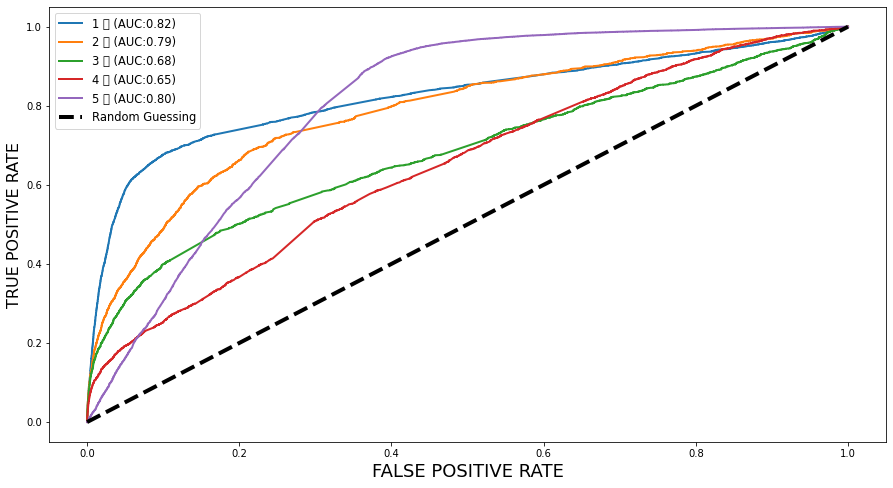

In [13]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show();

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

   
### <center>Thank you for reading🙂</center><br>
### <center>If you have any feedback, please let me know!</center><br>
